In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array

from Lumi import *
from TDR_Style import *
from Ratio_Plot import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
@numba.njit
def sgn(num):
    if (num >= 0):
        return 1
    else:
        return -1

### 1. Template Distribution

In [3]:
def AddHist_FTdist(file, branch, hist_pre1, hist_pre2, isData, xsec):
    
    if isData:
        print('is Data')
        init_branches = ['is_lepton_tight','jet_pt','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all',
                                                       'HLT_IsoMu24','HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt',
                                                      'HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']
        if not (branch in init_branches):
            init_branches.append(branch)
        branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

    else:
        print('is MC')
        init_branches = ['is_lepton_tight','jet_pt','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all','lepton_gen_matching','gen_weight',
                                                       'HLT_IsoMu24','HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt',
                                                      'HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']
        if not (branch in init_branches):
            init_branches.append(branch)
        branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]

        weight_lowpt = (1000*xsec*0.01485) / true_events
        weight_highpt = (1000*xsec*0.06281) / true_events
        lepton_gen_cut1 = branches.loc[:,'lepton_gen_matching'] == 1
        lepton_gen_cut2 = branches.loc[:,'lepton_gen_matching'] == 15
        
    HLT_cut1 = branches.loc[:,'HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    HLT_cut2 = branches.loc[:,'HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    
    met_cut = branches.loc[:,'met'] < 2000
    mt_cut = branches.loc[:,'mt'] < 20
    lepton_cut = abs(branches.loc[:,'lepton_pdgid']) == 11
#    pf_cut = branches.loc[:,'lepton_pfRelIso04_all'] < 0.4
    pf_cut = branches.loc[:,'is_lepton_tight'] == 0
    pt_edge = branches.loc[:,'lepton_pt'] < 25
    jet_pt = branches.loc[:,'jet_pt'] > 35
    
    if isData:
        arrays_0_25 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & jet_pt,:] 
        arrays_25_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & jet_pt,:] 
        for i in trange(0, len(arrays_0_25[branch]), desc=f'fill pt<25 part for {file}'):
            hist_pre1.Fill(float(arrays_0_25[branch].values[i]))
        for i in trange(0, len(arrays_25_Inf[branch]), desc=f'fill pt>25 part for {file}'):
            hist_pre2.Fill(float(arrays_25_Inf[branch].values[i]))
    
    else:
        if ('TTbar' in file) or ('QCD' in file):
            print ("QCD process\n")
            arrays_0_25 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & jet_pt,:] 
            arrays_25_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & jet_pt,:] 
        else:
            arrays_0_25 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:] 
            arrays_25_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:] 
        for i in trange(0, len(arrays_0_25[branch]), desc=f'fill pt<25 part for {file}'):
            hist_pre1.Fill(float(arrays_0_25[branch].values[i]), weight_lowpt*sgn(arrays_0_25['gen_weight'].values[i]))
        for i in trange(0, len(arrays_25_Inf[branch]), desc=f'fill pt>25 part for {file}'):
            hist_pre2.Fill(float(arrays_25_Inf[branch].values[i]), weight_highpt*sgn(arrays_25_Inf['gen_weight'].values[i]))
        
    print("DONE")

    return True

### MET dist

In [4]:
xbins = 20
xlow = 0
xup = 200
branch = 'met'

ptbins = [10, 13, 16, 20, 24, 28, 35, 45, 200]

hist_dist1_DATA = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_DATA = ROOT.TH1D("","",xbins, xlow, xup)

hist_dist1_DATA.Sumw2()
hist_dist2_DATA.Sumw2()

file_list = [
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016B.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016C.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016D.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016E.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016F.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016G.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016H.root'
]

for file in file_list:
    AddHist_FTdist(file, branch, hist_dist1_DATA, hist_dist2_DATA, 1, 1)

hist_dist1_WJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_WJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist1_ZJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_ZJets = ROOT.TH1D("","",xbins, xlow, xup)

hist_dist1_WJets.Sumw2()
hist_dist2_WJets.Sumw2()
hist_dist1_ZJets.Sumw2()
hist_dist2_ZJets.Sumw2()

file_WJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets2 = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'

AddHist_FTdist(file_WJets, branch, hist_dist1_WJets, hist_dist2_WJets, 0, 61526.7)
AddHist_FTdist(file_ZJets, branch, hist_dist1_ZJets, hist_dist2_ZJets, 0, 6077.22)
AddHist_FTdist(file_ZJets2, branch, hist_dist1_ZJets, hist_dist2_ZJets, 0, 18610)

hist_dist1_ttbar = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_ttbar = ROOT.TH1D("","",xbins, xlow, xup)

hist_dist1_ttbar.Sumw2()
hist_dist2_ttbar.Sumw2()

# -- Electron channel
file_list_QCD = [
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-30to50_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-120to170_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-170to300_EMEnriched_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-300toInf_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
]


xsec_list_QCD = [
    1327000,
    4908000,
    6396000,
    1989000,
    366500,
    66490,
    16480,
    1097
]



for i in range(len(file_list_QCD)):
    AddHist_FTdist(file_list_QCD[i], branch, hist_dist1_ttbar, hist_dist2_ttbar, 0, xsec_list_QCD[i])

is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016B.root: 100%|██████████| 237/237 [00:00<00:00, 59609.62it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016B.root: 100%|██████████| 7627/7627 [00:00<00:00, 237277.25it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016C.root: 100%|██████████| 39/39 [00:00<00:00, 141503.34it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016C.root: 100%|██████████| 1345/1345 [00:00<00:00, 224656.08it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016D.root: 100%|██████████| 42/42 [00:00<00:00, 141836.37it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016D.root: 100%|██████████| 2139/2139 [00:00<00:00, 233041.10it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016E.root: 100%|██████████| 30/30 [00:00<00:00, 66717.45it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016E.root: 100%|██████████| 1576/1576 [00:00<00:00, 107267.02it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016F.root: 100%|██████████| 14/14 [00:00<00:00, 42093.37it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016F.root: 100%|██████████| 488/488 [00:00<00:00, 109778.51it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016G.root: 100%|██████████| 22/22 [00:00<00:00, 93584.88it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016G.root: 100%|██████████| 521/521 [00:00<00:00, 178970.71it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016H.root: 100%|██████████| 13/13 [00:00<00:00, 33658.00it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016H.root: 100%|██████████| 313/313 [00:00<00:00, 196294.43it/s]


DONE
is MC


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 6490/6490 [00:00<00:00, 7246.02it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 5506/5506 [00:00<00:00, 88918.21it/s]


DONE
is MC


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 51874/51874 [00:00<00:00, 116663.31it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 49493/49493 [00:00<00:00, 118902.79it/s]


DONE
is MC


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 1724/1724 [00:00<00:00, 62011.01it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 466/466 [00:00<00:00, 67577.56it/s]


DONE
is MC
QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 391/391 [00:00<00:00, 113926.56it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 24/24 [00:00<00:00, 61643.17it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2018/2018 [00:00<00:00, 116314.71it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 211/211 [00:00<00:00, 109705.98it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-30to50_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 6032/6032 [00:00<00:00, 117877.47it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-30to50_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2891/2891 [00:00<00:00, 113527.26it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 3389/3389 [00:00<00:00, 115785.28it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 6388/6388 [00:00<00:00, 116521.11it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2251/2251 [00:00<00:00, 115608.24it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 7054/7054 [00:00<00:00, 117624.27it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-120to170_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1994/1994 [00:00<00:00, 56257.35it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-120to170_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 7322/7322 [00:00<00:00, 79000.80it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-170to300_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 685/685 [00:00<00:00, 107089.28it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-170to300_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2574/2574 [00:00<00:00, 114923.45it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-300toInf_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 490/490 [00:00<00:00, 115721.23it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-300toInf_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1722/1722 [00:00<00:00, 115804.19it/s]

DONE


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


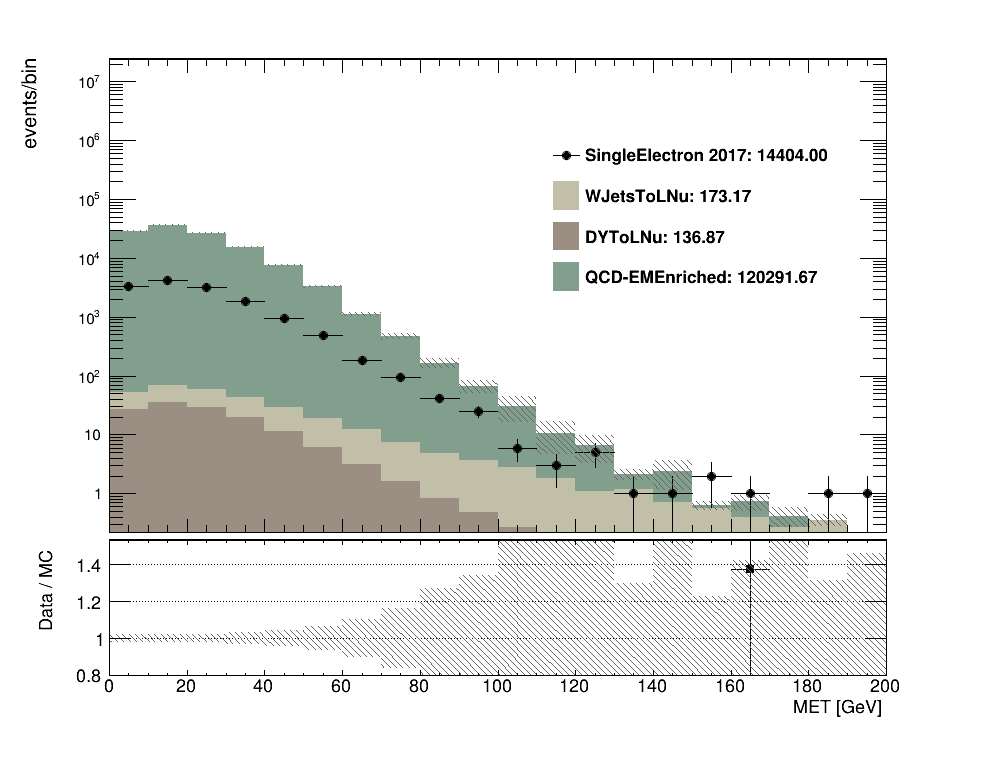

In [5]:
c1 = ROOT.TCanvas("","",1000,800)

def SetHistStyle_dist(hist, color, isData):
    if isData:
        hist.SetMarkerStyle(20)
        hist.SetMarkerColor(color)
    else:
        hist.SetFillColor(color)
        hist.SetFillStyle(4100)
        hist.SetLineColor(color)
        hist.SetLineStyle(0)
        hist.SetLineWidth(0)
    hist.SetYTitle('events/bin')
    hist.SetXTitle('MET [GeV]')
    # Adjust y-axis settings
    # hist.GetYaxis().SetNdivisions(105)
    hist.GetYaxis().SetTitleSize(25)
    hist.GetYaxis().SetTitleFont(43)
    hist.GetYaxis().SetTitleOffset(1.40)
    hist.GetYaxis().SetLabelFont(43)
    hist.GetYaxis().SetLabelSize(25)

    # Adjust x-axis settings
    hist.GetXaxis().SetTitleSize(25)
    hist.GetXaxis().SetTitleFont(43)
    hist.GetXaxis().SetTitleOffset(5.0)
    hist.GetXaxis().SetLabelFont(43)
    hist.GetXaxis().SetLabelSize(25)
    hist.SetStats(0)


SetHistStyle_dist(hist_dist1_WJets, 22, 0)
SetHistStyle_dist(hist_dist2_WJets, 22, 0)
SetHistStyle_dist(hist_dist1_ZJets, 27, 0)
SetHistStyle_dist(hist_dist2_ZJets, 27, 0)
SetHistStyle_dist(hist_dist1_ttbar, 32, 0)
SetHistStyle_dist(hist_dist2_ttbar, 32, 0)
SetHistStyle_dist(hist_dist1_DATA, 1, 1)
SetHistStyle_dist(hist_dist2_DATA, 1, 1)

hist_dist_WJets = hist_dist1_WJets.Clone()
hist_dist_WJets.Add(hist_dist2_WJets)
SetHistStyle_dist(hist_dist_WJets, 22, 0)
hist_dist_ZJets = hist_dist1_ZJets.Clone()
hist_dist_ZJets.Add(hist_dist2_ZJets)
SetHistStyle_dist(hist_dist_ZJets, 27, 0)
hist_dist_ttbar = hist_dist1_ttbar.Clone()
hist_dist_ttbar.Add(hist_dist2_ttbar)
SetHistStyle_dist(hist_dist_ttbar, 32, 0)

hs_dist = ROOT.THStack("",";M_{T,e} [GeV];events/bin")
hs_dist.Add(hist_dist_ZJets)
hs_dist.Add(hist_dist_WJets)
hs_dist.Add(hist_dist_ttbar)

MC_err = ROOT.TH1D("","",xbins,xlow,xup)
# MC_err = ROOT.TH1D("","",8,array('d',ptbins))
MC_err.Sumw2()
MC_err.Add(hist_dist1_WJets)
MC_err.Add(hist_dist2_WJets)
MC_err.Add(hist_dist1_ZJets)
MC_err.Add(hist_dist2_ZJets)
MC_err.Add(hist_dist1_ttbar)
MC_err.Add(hist_dist2_ttbar)
MC_err.SetFillColor(ROOT.kGray+2)
MC_err.SetFillStyle(3345)
MC_err.SetMarkerSize(0.)
MC_err.SetMarkerColor(ROOT.kGray+2)
MC_err.SetLineWidth(2)
MC_err.SetLineColor(0)
MC_err.SetStats(0)

hs_data = ROOT.TH1D("","",xbins,xlow,xup)
# hs_data = ROOT.TH1D("","",8,array('d',ptbins))
hs_data.Add(hist_dist1_DATA)
hs_data.Add(hist_dist2_DATA)
SetHistStyle_dist(hs_data, 1, 1)

legend = ROOT.TLegend(0.55, 0.45, 0.70, 0.75)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.035)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
# legend.AddEntry(hist_dist1_DATA,'Double Muon 2018')
legend.AddEntry(hist_dist1_DATA,f'SingleElectron 2017: {format(hs_data.GetSumOfWeights(), ".2f")}')
legend.AddEntry(hist_dist1_WJets,f'WJetsToLNu: {format(hist_dist_WJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ZJets,f'DYToLNu: {format(hist_dist_ZJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ttbar,f'QCD-EMEnriched: {format(hist_dist_ttbar.GetSumOfWeights(), ".2f")}','F')

c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.015)  # joins upper and lower plot
# pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)  # joins upper and lower plot
pad2.SetBottomMargin(0.3)
pad2.SetGridy()
pad2.Draw()

# draw everything
pad1.cd()
# hs_data.GetYaxis().SetMaxDigits(3)
hs_dist.Draw("HIST")
hs_dist.SetMaximum(10000000)
hs_dist.SetMinimum(1)
# hs_dist.GetXaxis().SetRangeUser(10,60)
hs_dist.GetXaxis().SetLabelSize(0)
hs_data.Draw("ep SAME")
MC_err.Draw("e2 SAME")
legend.Draw("SAME")
ROOT.gPad.SetLogy()
ROOT.gPad.RedrawAxis()


# h1.GetXaxis().SetLabelSize(0)
pad2.cd()
h3 = createRatio(hs_data, MC_err)
h4 = createRatio(MC_err, MC_err)
h3.Draw("ep")
# h3.GetXaxis().SetRangeUser(10,60)
h4.Draw("e2 SAME")
ROOT.gPad.RedrawAxis()

#CMS_lumi(pad1, 0, 0)
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.png')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.pdf')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.png')

## SF

In [6]:
bin_left = hist_dist1_WJets.FindBin(0)
bin_right = hist_dist1_WJets.FindBin(20)

WJets_yields = hist_dist1_WJets.Integral(bin_left,bin_right) + hist_dist2_WJets.Integral(bin_left,bin_right)
ZJets_yields = hist_dist1_ZJets.Integral(bin_left,bin_right) + hist_dist2_ZJets.Integral(bin_left,bin_right)
ttbar_yields = hist_dist1_ttbar.Integral(bin_left,bin_right) + hist_dist2_ttbar.Integral(bin_left,bin_right)
data_yields = hist_dist1_DATA.Integral(bin_left,bin_right) + hist_dist2_DATA.Integral(bin_left,bin_right)

print (hist_dist1_WJets.FindBin(0),hist_dist1_WJets.FindBin(20))
print (f"WJets yields in EWK CR: {WJets_yields}")
print (f"ZJets yields in EWK CR: {ZJets_yields}")
print (f"QCD yields in EWK CR: {ttbar_yields}")
print (f"data yields in EWK CR: {data_yields}")
print (f"SF = {data_yields} / {WJets_yields + ZJets_yields + ttbar_yields}  = {data_yields/(WJets_yields+ZJets_yields+ttbar_yields)}")
SF = data_yields/(WJets_yields+ZJets_yields+ttbar_yields)

1 3
WJets yields in EWK CR: 87.52484494857197
ZJets yields in EWK CR: 92.60105181038294
QCD yields in EWK CR: 92199.65580657686
data yields in EWK CR: 10728.0
SF = 10728.0 / 92379.78170333582  = 0.11612930667504072


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


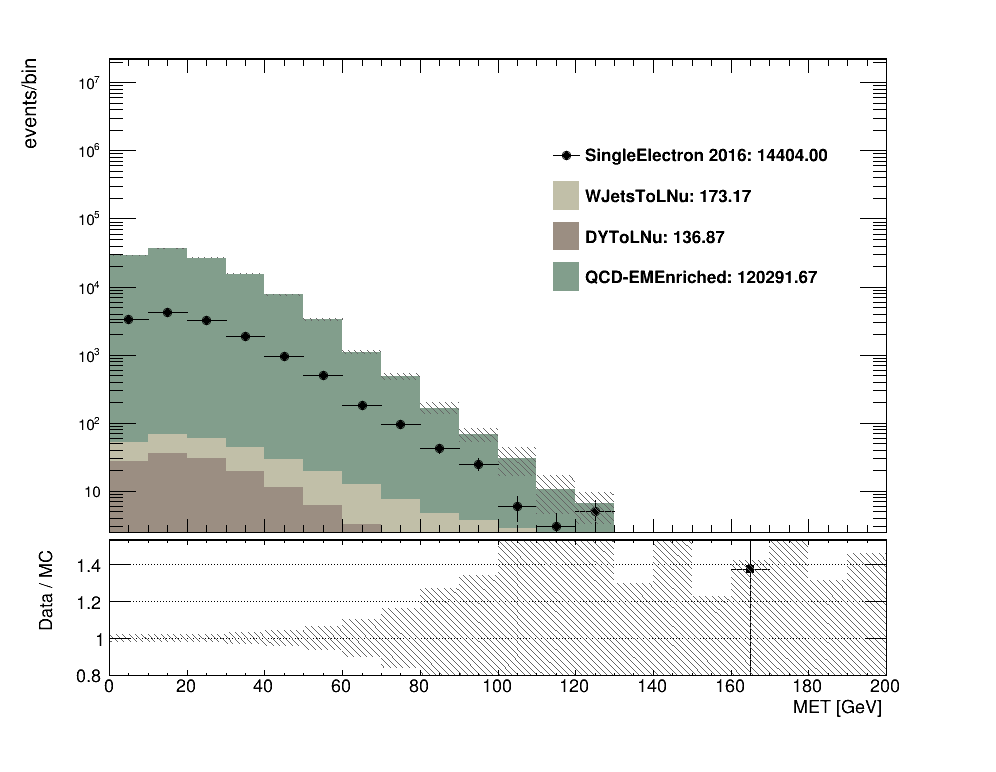

In [7]:
c1 = ROOT.TCanvas("","",1000,800)

def SetHistStyle_dist(hist, color, isData):
    if isData:
        hist.SetMarkerStyle(20)
        hist.SetMarkerColor(color)
    else:
        hist.SetFillColor(color)
        hist.SetFillStyle(4100)
        hist.SetLineColor(color)
        hist.SetLineStyle(0)
        hist.SetLineWidth(0)
    hist.SetYTitle('events/bin')
    hist.SetXTitle('MET [GeV]')
    # Adjust y-axis settings
    # hist.GetYaxis().SetNdivisions(105)
    hist.GetYaxis().SetTitleSize(25)
    hist.GetYaxis().SetTitleFont(43)
    hist.GetYaxis().SetTitleOffset(1.40)
    hist.GetYaxis().SetLabelFont(43)
    hist.GetYaxis().SetLabelSize(25)

    # Adjust x-axis settings
    hist.GetXaxis().SetTitleSize(25)
    hist.GetXaxis().SetTitleFont(43)
    hist.GetXaxis().SetTitleOffset(5.0)
    hist.GetXaxis().SetLabelFont(43)
    hist.GetXaxis().SetLabelSize(25)
    hist.SetStats(0)


SetHistStyle_dist(hist_dist1_WJets, 22, 0)
SetHistStyle_dist(hist_dist2_WJets, 22, 0)
SetHistStyle_dist(hist_dist1_ZJets, 27, 0)
SetHistStyle_dist(hist_dist2_ZJets, 27, 0)
SetHistStyle_dist(hist_dist1_ttbar, 32, 0)
SetHistStyle_dist(hist_dist2_ttbar, 32, 0)
SetHistStyle_dist(hist_dist1_DATA, 1, 1)
SetHistStyle_dist(hist_dist2_DATA, 1, 1)

hist_dist_WJets = hist_dist1_WJets.Clone()
hist_dist_WJets.Add(hist_dist2_WJets)
SetHistStyle_dist(hist_dist_WJets, 22, 0)
hist_dist_ZJets = hist_dist1_ZJets.Clone()
hist_dist_ZJets.Add(hist_dist2_ZJets)
SetHistStyle_dist(hist_dist_ZJets, 27, 0)
hist_dist_ttbar = hist_dist1_ttbar.Clone()
hist_dist_ttbar.Add(hist_dist2_ttbar)
SetHistStyle_dist(hist_dist_ttbar, 32, 0)

hs_dist = ROOT.THStack("",";M_{T,e} [GeV];events/bin")
hs_dist.Add(hist_dist_ZJets)
hs_dist.Add(hist_dist_WJets)
hs_dist.Add(hist_dist_ttbar)

MC_err = ROOT.TH1D("","",xbins,xlow,xup)
# MC_err = ROOT.TH1D("","",8,array('d',ptbins))
MC_err.Sumw2()
MC_err.Add(hist_dist1_WJets)
MC_err.Add(hist_dist2_WJets)
MC_err.Add(hist_dist1_ZJets)
MC_err.Add(hist_dist2_ZJets)
MC_err.Add(hist_dist1_ttbar)
MC_err.Add(hist_dist2_ttbar)
MC_err.SetFillColor(ROOT.kGray+2)
MC_err.SetFillStyle(3345)
MC_err.SetMarkerSize(0.)
MC_err.SetMarkerColor(ROOT.kGray+2)
MC_err.SetLineWidth(2)
MC_err.SetLineColor(0)
MC_err.SetStats(0)

hs_data = ROOT.TH1D("","",xbins,xlow,xup)
# hs_data = ROOT.TH1D("","",8,array('d',ptbins))
hs_data.Add(hist_dist1_DATA)
hs_data.Add(hist_dist2_DATA)
SetHistStyle_dist(hs_data, 1, 1)

legend = ROOT.TLegend(0.55, 0.45, 0.70, 0.75)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.035)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
# legend.AddEntry(hist_dist1_DATA,'Double Muon 2018')
legend.AddEntry(hist_dist1_DATA,f'SingleElectron 2016: {format(hs_data.GetSumOfWeights(), ".2f")}')
legend.AddEntry(hist_dist1_WJets,f'WJetsToLNu: {format(hist_dist_WJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ZJets,f'DYToLNu: {format(hist_dist_ZJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ttbar,f'QCD-EMEnriched: {format(hist_dist_ttbar.GetSumOfWeights(), ".2f")}','F')

c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.015)  # joins upper and lower plot
# pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)  # joins upper and lower plot
pad2.SetBottomMargin(0.3)
pad2.SetGridy()
pad2.Draw()

# draw everything
pad1.cd()
# hs_data.GetYaxis().SetMaxDigits(3)
hs_dist.Draw("HIST")
hs_dist.SetMaximum(10000000)
hs_dist.SetMinimum(10)
# hs_dist.GetXaxis().SetRangeUser(10,60)
hs_dist.GetXaxis().SetLabelSize(0)
hs_data.Draw("ep SAME")
MC_err.Draw("e2 SAME")
legend.Draw("SAME")
ROOT.gPad.SetLogy()
ROOT.gPad.RedrawAxis()


# h1.GetXaxis().SetLabelSize(0)
pad2.cd()
h3 = createRatio(hs_data, MC_err)
h4 = createRatio(MC_err, MC_err)
h3.Draw("ep")
# h3.GetXaxis().SetRangeUser(10,60)
h4.Draw("e2 SAME")
ROOT.gPad.RedrawAxis()

#CMS_lumi(pad1, 0, 0)
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.png')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.pdf')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.png')

0.16414243938538106
0.016918770070737662
0.20070948252458032
0.03070052402228921


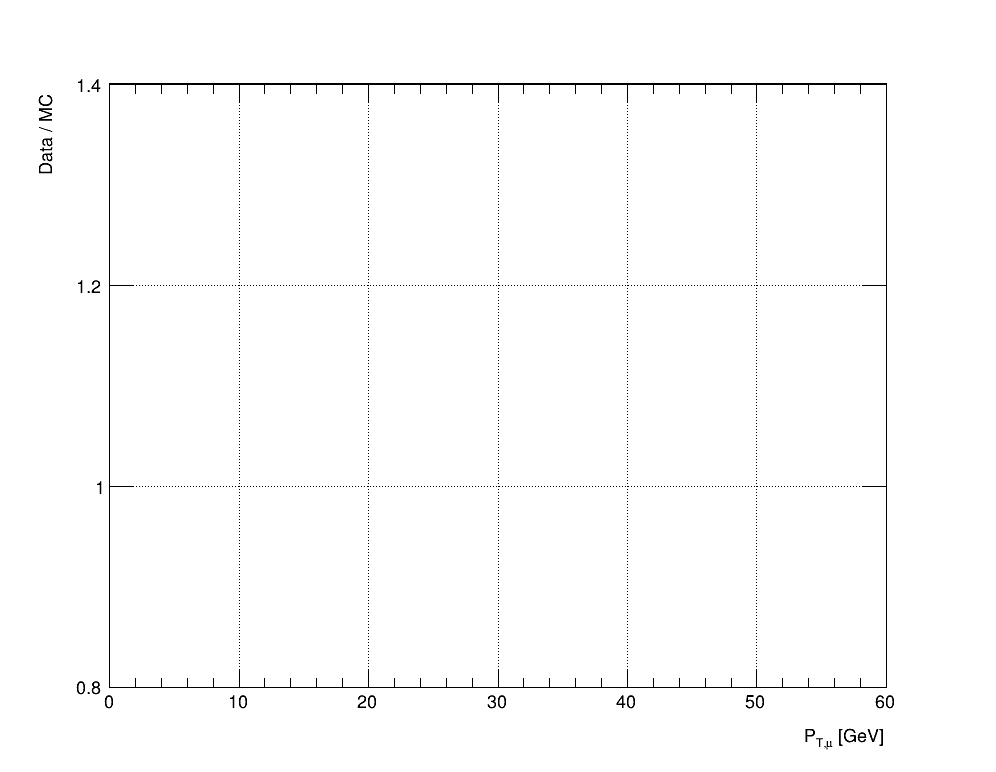

In [8]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()


h3.Draw('ep')
h3.SetXTitle('P_{T,#mu} [GeV]')
h3.GetXaxis().SetTitleOffset(1.6)
h3.GetXaxis().SetRangeUser(0,60)
h3.SetMaximum(1.4)
#h3.SetMinimum(0)
ROOT.gPad.SetGridy()
ROOT.gPad.SetGridx()

print(h3.GetBinContent(7))
print(h3.GetBinError(7))
print(h3.GetBinContent(8))
print(h3.GetBinError(8))

## Electron Fake Rate

In [10]:
def AddHist_FR_Ele(file, h_nume_e, h_deno_e, isAdd, isData, lumi_Ele12, lumi_Ele23, xsec):
    
    if isData:
        print('is Data')
        branches = uproot.open(file+':Events').arrays(['jet_pt','is_lepton_tight','mt','met','lepton_pt','lepton_eta','lepton_pdgid','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30','hlt'], library='pd')
    else:
        print('is MC')
        branches = uproot.open(file+':Events').arrays(['jet_pt','is_lepton_tight','mt','met','lepton_pt','lepton_eta','lepton_pdgid',
                                                       'lepton_gen_matching','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30','hlt','gen_weight'], library='pd')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        weight_lowpt = (1000*lumi_Ele12*xsec*isAdd) / true_events
        weight_highpt = (1000*lumi_Ele23*xsec*isAdd) / true_events
        lepton_gen_cut1 = branches.loc[:,'lepton_gen_matching'] == 1
        lepton_gen_cut2 = branches.loc[:,'lepton_gen_matching'] == 15
        
    HLT_cut1 = branches.loc[:,'HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    HLT_cut2 = branches.loc[:,'HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    met_cut = branches.loc[:,'met'] < 20
    mt_cut = branches.loc[:,'mt'] < 20
    Electron_cut = abs(branches.loc[:,'lepton_pdgid']) == 11
    pt_edge = branches.loc[:,'lepton_pt'] < 25
    jet_pt = branches.loc[:,'jet_pt'] >35

    
    overflow_Y = h_deno_e.GetYaxis().GetBinUpEdge(h_deno_e.GetNbinsY())
    center_upper_Y = h_deno_e.GetYaxis().GetBinCenter(h_deno_e.GetNbinsY())
    
    if isData:
        deno_e_lowpt = branches.loc[HLT_cut1 & pt_edge & Electron_cut & met_cut & mt_cut & jet_pt,:]
        deno_e_highpt = branches.loc[HLT_cut2 & ~pt_edge & Electron_cut & met_cut & mt_cut & jet_pt,:]
        
        
        for i in trange(0, len(deno_e_lowpt['lepton_pt']), desc=f'fill pt < 25 GeV for {file}'):
            if float(deno_e_lowpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]))
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y)
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y)
                
        for i in trange(0, len(deno_e_highpt['lepton_pt']), desc=f'fill pt > 25 GeV for {file}'):
            if float(deno_e_highpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]))
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y)
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y)
                    
                
    else:
        deno_e_lowpt = branches.loc[HLT_cut1 & pt_edge & Electron_cut & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:].copy()
        deno_e_highpt = branches.loc[HLT_cut2 & ~pt_edge & Electron_cut & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:].copy()
        
        # Add SF
        deno_e_highpt.loc[:,'SF'] = 1
        deno_e_highpt.loc[(deno_e_highpt['lepton_pt'] >= 35) & (deno_e_highpt['lepton_pt'] < 45), 'SF'] = 1
        deno_e_highpt.loc[deno_e_highpt['lepton_pt'] >= 45 , 'SF'] = 1
        
        
        for i in trange(0, len(deno_e_lowpt['lepton_pt']), desc=f'fill pt < 25 GeV for {file}'):
            if float(deno_e_lowpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]), weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]), weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y, weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y, weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
                
        for i in trange(0, len(deno_e_highpt['lepton_pt']), desc=f'fill pt > 25 GeV for {file}'):
            if float(deno_e_highpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]), deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]), deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y, deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y, deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))


    deno_counts = 0
    for i in range(h_deno_e.GetNbinsX()):
        for j in range(h_deno_e.GetNbinsY()):
            deno_counts += h_deno_e.GetBinContent(i+1,j+1) 

    nume_counts = 0
    for i in range(h_nume_e.GetNbinsX()):
        for j in range(h_nume_e.GetNbinsY()):
            nume_counts += h_nume_e.GetBinContent(i+1,j+1) 

    print (f"normalized deno :{deno_counts}")
    print (f"normalized nume :{nume_counts}")

Data processing

In [11]:
ybins = [10, 13, 16, 20, 24, 28, 35, 45, 60]
xbins = [.0, 0.5, 1.0, 1.5, 2.0, 2.5]

from array import array
h_deno_e = ROOT.TH2D("","", 5, array('d',xbins), 8, array('d',ybins))
h_deno_e.StatOverflows(1)
h_deno_e.Sumw2()
h_nume_e = ROOT.TH2D("","", 5, array('d',xbins), 8, array('d',ybins))
h_nume_e.StatOverflows(1)
h_nume_e.Sumw2()



file_list_E = [
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016B.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016C.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016D.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016E.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016F.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016G.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016H.root'
]
for file_DATA in file_list_E:
    AddHist_FR_Ele(file_DATA, h_nume_e, h_deno_e, 1, 1, 0, 0, 0)

is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016B.root: 100%|██████████| 322/322 [00:00<00:00, 28713.45it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016B.root: 100%|██████████| 12608/12608 [00:00<00:00, 45924.90it/s]


normalized deno :12900.0
normalized nume :8717.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016C.root: 100%|██████████| 39/39 [00:00<00:00, 35895.95it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016C.root: 100%|██████████| 2154/2154 [00:00<00:00, 46833.12it/s]


normalized deno :15091.0
normalized nume :10189.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016D.root: 100%|██████████| 51/51 [00:00<00:00, 39307.15it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016D.root: 100%|██████████| 3578/3578 [00:00<00:00, 28330.90it/s]


normalized deno :18713.0
normalized nume :12667.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016E.root: 100%|██████████| 28/28 [00:00<00:00, 22335.59it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016E.root: 100%|██████████| 2588/2588 [00:00<00:00, 29075.38it/s]


normalized deno :21323.0
normalized nume :14438.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016F.root: 100%|██████████| 21/21 [00:00<00:00, 26578.27it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016F.root: 100%|██████████| 828/828 [00:00<00:00, 37548.34it/s]


normalized deno :22169.0
normalized nume :15064.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016G.root: 100%|██████████| 29/29 [00:00<00:00, 22748.24it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016G.root: 100%|██████████| 1112/1112 [00:00<00:00, 37065.23it/s]


normalized deno :23310.0
normalized nume :15949.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016H.root: 100%|██████████| 16/16 [00:00<00:00, 24910.49it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/SingleElectron_Run2016H.root: 100%|██████████| 845/845 [00:00<00:00, 36859.10it/s]

normalized deno :24168.0
normalized nume :16662.0


MC processing

In [12]:
file_WJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets2 = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'

xsec_WJets = 61526.7  
xsec_ZJets = 6077.22 
xsec_ZJets2 = 18610

lumi_Ele12 = 0.01485 # HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30 2018 lumi
lumi_Ele23 = 0.06281 # HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30 2018 lumi

AddHist_FR_Ele(file_WJets, h_nume_e, h_deno_e, -1, 0, lumi_Ele12, lumi_Ele23, xsec_WJets)
AddHist_FR_Ele(file_ZJets, h_nume_e, h_deno_e, -1, 0, lumi_Ele12, lumi_Ele23, xsec_ZJets)
AddHist_FR_Ele(file_ZJets2, h_nume_e, h_deno_e, -1, 0, lumi_Ele12, lumi_Ele23, xsec_ZJets2)
print (lumi_Ele12, lumi_Ele23, xsec_WJets)
print (lumi_Ele12, lumi_Ele23, xsec_ZJets)
print (lumi_Ele12, lumi_Ele23, xsec_ZJets2)

is MC


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 17507/17507 [00:00<00:00, 25737.43it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 69470/69470 [00:04<00:00, 16943.61it/s]


normalized deno :22347.132394526212
normalized nume :14898.502323075392
is MC


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 195555/195555 [00:07<00:00, 26223.41it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 729955/729955 [00:45<00:00, 16149.12it/s]


normalized deno :20844.05982207643
normalized nume :13449.312208226705
is MC


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 9469/9469 [00:00<00:00, 22709.65it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 6857/6857 [00:00<00:00, 18142.13it/s]


normalized deno :20664.722146884786
normalized nume :13278.773703611443
0.01485 0.06281 61526.7
0.01485 0.06281 6077.22
0.01485 0.06281 18610


35.86 fb^{-1} (13 TeV)


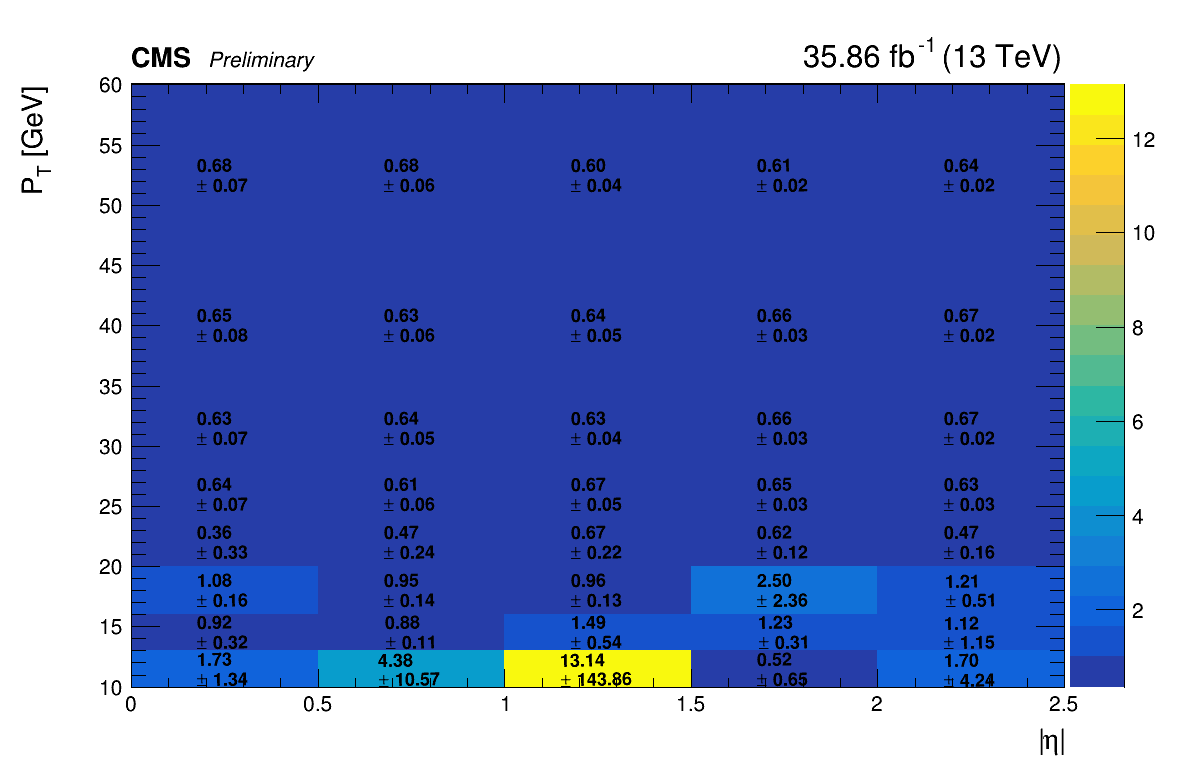

In [13]:
fake_rate_e = h_nume_e.Clone("fake_rate_e")
fake_rate_e.Divide(h_deno_e)

fake_rate_e.SetDirectory(0)
c1 = ROOT.TCanvas("","",1200,800)
fake_rate_e.SetStats(0)
fake_rate_e.SetXTitle("|#eta|")
fake_rate_e.SetYTitle("P_{T} [GeV]")
fake_rate_e.SetMarkerSize(1.3)
ROOT.gStyle.SetPaintTextFormat('4.2f')
fake_rate_e.Draw("COLZe TEXT")
c1.Draw()
CMS_lumi(c1,0,0)
# c1.SaveAs('Fake_Lepton/2017/FR_Electron_data_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/FR_Electron_data_2017_new.png')